In [19]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# !! need to insert this path to load h5py without errors!
#  (otherwise Python tries to load the h5py in default site-packages and throws an ImportError)
import sys
sys.path.insert(0, '/work2/08811/aew492/frontera/venv/illustris3.9/lib/python3.9/site-packages')

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import interpolate
import astropy.units as u
import astropy.cosmology.units as cu
import os
import illustris_python as il

sys.path.insert(0, '/work2/08811/aew492/frontera/small-scale_cross-corrs/code')
from xcorr_cases import HSC_Xcorr
from illustris_sim import TNGSim
import tools

### HSC photometric sample x DESI ELG reference sample

To start, take the target number densities from one HSC photometric redshift bin, and take fixed (constant over redshift) number density for the reference sample.

In [4]:
# main inputs
snapshotss = [
    np.arange(59, 84), # center at z~0.45
    np.arange(47, 70), # center at z=0.75
    np.arange(40, 62),  # center at z=1.
    np.arange(35, 54)  # center at z=1.25
]

# the photo-z bins
photzbins = np.arange(0, 4) # skipping bin 4 for now, since DESI ELG data only goes out to z=1.59

# galaxy number density
density = 2e-4 * (cu.littleh / u.Mpc)**3

hsc_kwargs = dict(density_type='fixed', density=density, reference_survey='DESI', reference_tracer='ELG')

#### HSC photometric redshift kernels

warning! input redshift (1.6) outside DESI density table range (0.00-1.59)
warning! input redshift (1.67) outside DESI density table range (0.00-1.59)
warning! input redshift (1.74) outside DESI density table range (0.00-1.59)
warning! input redshift (1.82) outside DESI density table range (0.00-1.59)


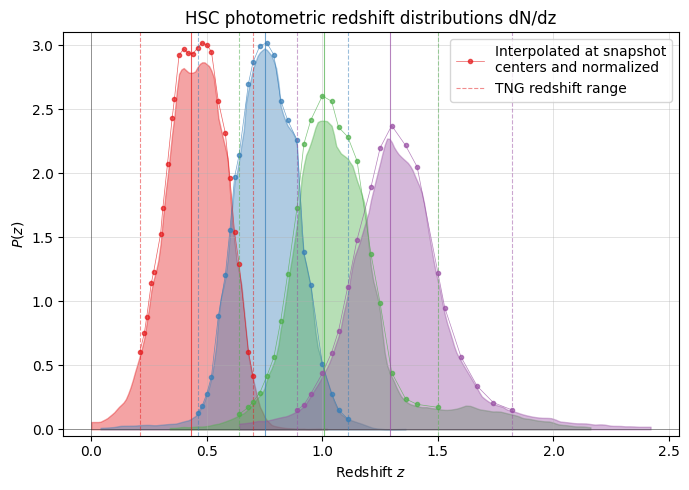

In [5]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
norm = mpl.colors.Normalize(vmin=min(photzbins), vmax=9)
smap = mpl.cm.ScalarMappable(norm=norm, cmap='Set1')
ax.axhline(0, c='k', lw=0.5, alpha=0.5)
ax.axvline(0, c='k', lw=0.5, alpha=0.5)
ax.set_ylim(-.05, 3.1)
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Redshift $z$')
ax.set_ylabel(r'$P(z)$')
ax.set_title(r'HSC photometric redshift distributions dN/dz')
for i, (snapshots, photzbin) in enumerate(zip(snapshotss, photzbins)):
    # instantiate spherex set for cross-correlation
    X = HSC_Xcorr(snapshots, photzbin, **hsc_kwargs)
    c = smap.to_rgba(X.photzbin) # color from which redshift bin
    ax.fill_between(X.photzdata['z'], X.photzdata['pz'], color=c, alpha=0.4)
    #ax.axvline(min(X.redshifts), c=smap.to_rgba(X.photzbin), alpha=0.7)
    #ax.axvline(max(X.redshifts), c=smap.to_rgba(X.photzbin), alpha=0.7)
    ax.axvline(np.mean(X.redshifts), c=c, alpha=0.7, ls='-', lw=0.8)
    label = 'Interpolated at snapshot\ncenters and normalized' if i == 0 else ''
    ax.plot(X.redshifts, X.pz, '.-', alpha=0.7, lw=0.5, c=c, label=label)
    label = 'TNG redshift range' if i == 0 else ''
    ax.axvline(min(X.redshifts), c=c, alpha=0.5, lw=0.8, ls='--', label=label)
    ax.axvline(max(X.redshifts), c=c, alpha=0.5, lw=0.8, ls='--')
ax.legend()

warning! input redshift (1.6) outside DESI density table range (0.00-1.59)
warning! input redshift (1.67) outside DESI density table range (0.00-1.59)
warning! input redshift (1.74) outside DESI density table range (0.00-1.59)
warning! input redshift (1.82) outside DESI density table range (0.00-1.59)


[]

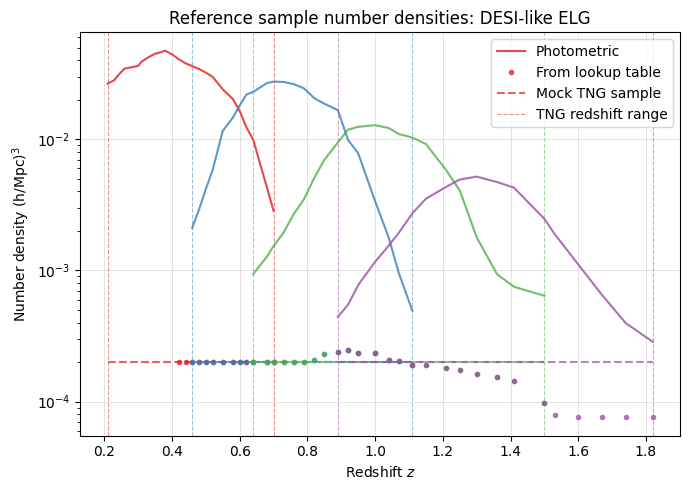

In [6]:
# plot the spectroscopic densities
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
norm = mpl.colors.Normalize(vmin=min(photzbins), vmax=9)
smap = mpl.cm.ScalarMappable(norm=norm, cmap='Set1')
for i, (snapshots, photzbin) in enumerate(zip(snapshotss, photzbins)):
    # instantiate spherex set for cross-correlation
    X = HSC_Xcorr(snapshots, photzbin, **hsc_kwargs)
    c = smap.to_rgba(X.photzbin) # color from which redshift bin
    
    # photometric densities
    label = 'Photometric' if i == 0 else ''
    ax.plot(X.redshifts, X.ns_phot, '-', c=c, alpha=0.8, label=label)
    # spectroscopic densities
    label = 'From lookup table' if i == 0 else ''
    ax.plot(X.redshifts, X.target_ns, '.', c=c, lw=0.5, alpha=0.7, label=label)
    label = 'Mock TNG sample' if i == 0 else ''
    ax.plot(X.redshifts, X.ns, '--', c=c, alpha=0.7, label=label)
    
    label = 'TNG redshift range' if i == 0 else ''
    ax.axvline(min(X.redshifts), c=c, alpha=0.5, lw=0.8, ls='--', label=label)
    ax.axvline(max(X.redshifts), c=c, alpha=0.5, lw=0.8, ls='--')

ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Redshift $z$')
ax.set_ylabel(r'Number density (h/Mpc)$^3$')
ax.set_title(f'Reference sample number densities: {X.reference_survey}-like {X.reference_tracer}')
ax.legend()
ax.semilogy()

#### now in the last redshift bin:

In [7]:
# construct the photometric and spectroscopic galaxies in each snapshot
X.construct_photometric_galaxy_samples()
X.construct_spectroscopic_galaxy_samples()

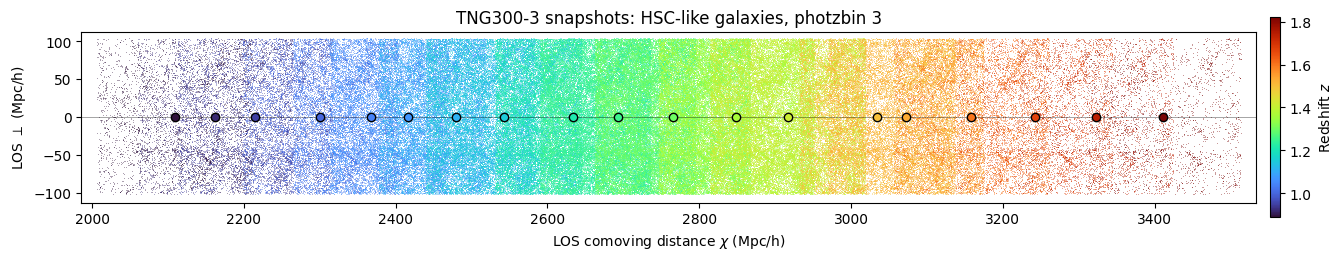

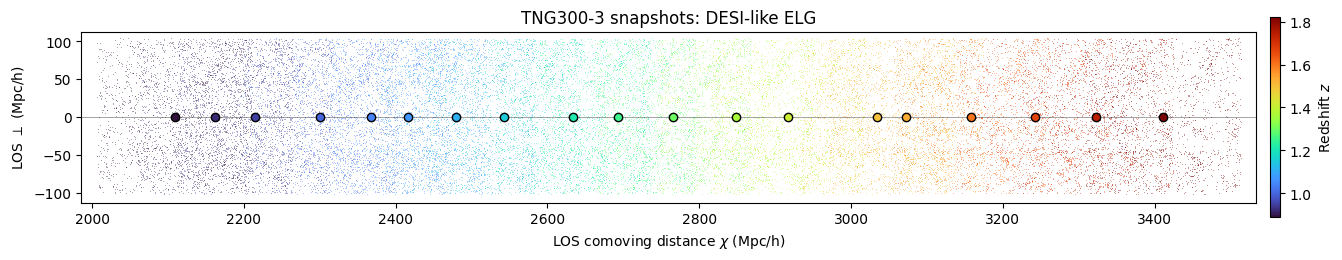

In [8]:
# plot both samples
norm = mpl.colors.Normalize(vmin=min(X.redshifts), vmax=max(X.redshifts))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='turbo')

# photometric
fig, ax = plt.subplots(figsize=(15,2.6), tight_layout=True)
for i, chi in enumerate(X.chis):
    gal_pos_phot_ = np.copy(X.gal_pos_phots[i])
    gal_pos_phot_[:,2] += chi
    kwargs = dict(c=smap.to_rgba(X.redshifts[i]), ls='None')
    ax.plot(gal_pos_phot_[:,2], gal_pos_phot_[:,0], marker=',', alpha=0.4, **kwargs)
    ax.plot(chi, 0, marker='o', c=smap.to_rgba(X.redshifts[i]), mec='k', zorder=100)
    ax.axvline((chi - X.boxsize/2).value, alpha=0.8, **kwargs)
    ax.axvline((chi + X.boxsize/2).value, alpha=0.8, **kwargs)
ax.axhline(0, c='k', alpha=0.5, lw=0.5)
ax.set_aspect('equal')
ax.set_xlim((min(X.chis)-0.6*X.boxsize).value, (max(X.chis)+0.6*X.boxsize).value)
ax.set_xlabel(r'LOS comoving distance $\chi$ (Mpc/h)')
ax.set_ylabel(r'LOS $\perp$ (Mpc/h)')
ax.set_title(f'{X.sim} snapshots: HSC-like galaxies, photzbin {X.photzbin}')
fig.colorbar(smap, ax=ax, label='Redshift $z$', pad=0.01)

# spectroscopic
fig, ax = plt.subplots(figsize=(15,2.6), tight_layout=True)
for i, chi in enumerate(X.chis):
    gal_pos_spec_ = np.copy(X.gal_pos_specs[i])
    gal_pos_spec_[:,2] += chi
    kwargs = dict(c=smap.to_rgba(X.redshifts[i]), ls='None')
    ax.plot(gal_pos_spec_[:,2], gal_pos_spec_[:,0], marker=',', alpha=0.4, **kwargs)
    ax.plot(chi, 0, marker='o', c=smap.to_rgba(X.redshifts[i]), mec='k', zorder=100)
    ax.axvline((chi - X.boxsize/2).value, alpha=0.8, **kwargs)
    ax.axvline((chi + X.boxsize/2).value, alpha=0.8, **kwargs)
ax.axhline(0, c='k', alpha=0.5, lw=0.5)
ax.set_aspect('equal')
ax.set_xlim((min(X.chis)-0.6*X.boxsize).value, (max(X.chis)+0.6*X.boxsize).value)
ax.set_xlabel(r'LOS comoving distance $\chi$ (Mpc/h)')
ax.set_ylabel(r'LOS $\perp$ (Mpc/h)')
ax.set_title(f'{X.sim} snapshots: {X.reference_survey}-like {X.reference_tracer}')
fig.colorbar(smap, ax=ax, label='Redshift $z$', pad=0.01)

In [10]:
# compute angular cross-correlation from pair counts
X.compute_wthetax_from_pair_counts(verbose=False)

In [11]:
# and from linear theory, from the photometric (HSC) sample
gal_pos_phots = X._fetch_gal_pos_phots(None) # gross, need to fix this computation
X.compute_wthetax_linear_theory(gal_pos_phots=gal_pos_phots, verbose=True)

computing projected autocorr. from linear theory from photometric sample


/work2/08811/aew492/frontera/small-scale_cross-corrs/code/linear_theory.py:78: RuntimeWarning: invalid value encountered in sqrt
  ratio = np.sqrt(galxgal / tools.linear_2pcf(redshift, ravg))


calculating bias:	19 of 19 (z=1.82)


Text(0.45, 0.95, 'Phot. x spec. cross-correlation, $z=$0.89-1.82, phot-z bin 3')

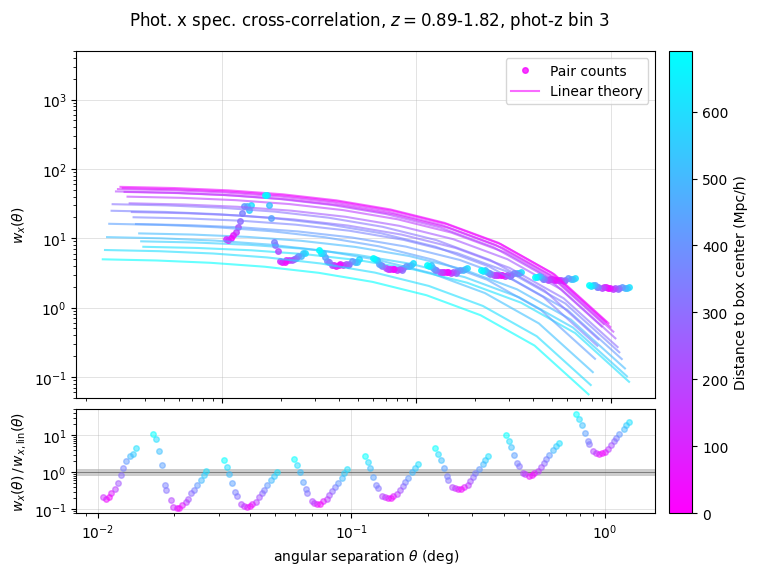

In [15]:
# plot the cross-correlations
norm = mpl.colors.Normalize(vmin=0, vmax=np.amax(np.abs(X.chis-X.central_chi).value))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='cool_r')
fig = plt.figure(figsize=(9,6))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[1,0.3], hspace=0.05)

ax0 = fig.add_subplot(gs[0])
for i, w in enumerate(X.wthetax):
    kwargs = dict(c=smap.to_rgba(np.abs(X.chis[i] - X.central_chi).value))
    label = 'Pair counts' if i==len(X.wthetax)//2 else ''
    ax0.plot(X.theta_avg[i], w, marker='o', ms=4, ls='None', alpha=0.8, label=label, **kwargs)
    label = 'Linear theory' if i==len(X.wthetax)//2 else ''
    ax0.plot(X.theta_avg[i], X.wthetax_lin[i], alpha=0.6, label=label, **kwargs)
# secax = ax0.secondary_xaxis('top', functions=(theta_to_r_comov_, r_comov_to_theta_))
# secax.set_xlabel(r'separation $r_p$ (Mpc/h)')
ax0.set_ylim(5e-2,5e3)
ax0.set_ylabel(r'$w_x(\theta)$')
ax0.legend()

ax1 = fig.add_subplot(gs[1])
ax1.axhline(1., c='k', alpha=0.5, lw=0.5)
for i, w in enumerate(X.wthetax):
    ax1.plot(X.theta_avg[i], w / X.wthetax_lin[i], marker='o', ms=4, alpha=0.5, ls='None',
             c=smap.to_rgba(np.abs(X.chis[i] - X.central_chi).value))
ax1.axhspan(0.8, 1.2, facecolor='k', alpha=0.2)
ax1.set_ylabel(r'$w_x(\theta)\,/\,w_{x,\mathrm{lin}}(\theta)$')
ax1.set_xlabel(r'angular separation $\theta$ (deg)')

for ax in (ax0, ax1):
    ax.loglog()
    ax.grid(alpha=0.5, lw=0.5)
    # ax.set_xlim(min(X.theta_avg[len(snapshots)//2])-5e-4, max(X.theta_avg[len(snapshots)//2])+1e-1) # hacky

fig.colorbar(smap, ax=[ax0,ax1], label='Distance to box center (Mpc/h)', pad=0.02)
fig.suptitle(r'Phot. x spec. cross-correlation, $z=$'f'{min(X.redshifts)}-{max(X.redshifts)}, phot-z bin {X.photzbin}',
             x=0.45, y=0.95)

Text(0.45, 0.95, 'Phot. x spec. cross-correlation, $z=$0.89-1.82, phot-z bin 3')

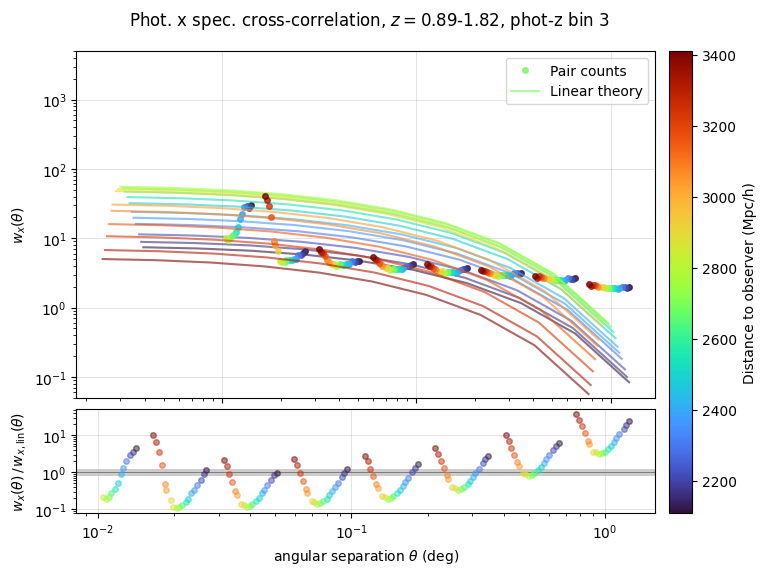

In [20]:
# different color bar: chi
# plot the cross-correlations
norm = mpl.colors.Normalize(vmin=min(X.chis).value, vmax=max(X.chis).value)
smap = mpl.cm.ScalarMappable(norm=norm, cmap='turbo')
fig = plt.figure(figsize=(9,6))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[1,0.3], hspace=0.05)

ax0 = fig.add_subplot(gs[0])
for i, w in enumerate(X.wthetax):
    kwargs = dict(c=smap.to_rgba(X.chis[i]))
    label = 'Pair counts' if i==len(X.wthetax)//2 else ''
    ax0.plot(X.theta_avg[i], w, marker='o', ms=4, ls='None', alpha=0.8, label=label, **kwargs)
    label = 'Linear theory' if i==len(X.wthetax)//2 else ''
    ax0.plot(X.theta_avg[i], X.wthetax_lin[i], alpha=0.6, label=label, **kwargs)
# secax = ax0.secondary_xaxis('top', functions=(theta_to_r_comov_, r_comov_to_theta_))
# secax.set_xlabel(r'separation $r_p$ (Mpc/h)')
ax0.set_ylim(5e-2,5e3)
ax0.set_ylabel(r'$w_x(\theta)$')
ax0.legend()

ax1 = fig.add_subplot(gs[1])
ax1.axhline(1., c='k', alpha=0.5, lw=0.5)
for i, w in enumerate(X.wthetax):
    ax1.plot(X.theta_avg[i], w / X.wthetax_lin[i], marker='o', ms=4, alpha=0.5, ls='None',
             c=smap.to_rgba(X.chis[i]))
ax1.axhspan(0.8, 1.2, facecolor='k', alpha=0.2)
ax1.set_ylabel(r'$w_x(\theta)\,/\,w_{x,\mathrm{lin}}(\theta)$')
ax1.set_xlabel(r'angular separation $\theta$ (deg)')

for ax in (ax0, ax1):
    ax.loglog()
    ax.grid(alpha=0.5, lw=0.5)
    # ax.set_xlim(min(X.theta_avg[len(snapshots)//2])-5e-4, max(X.theta_avg[len(snapshots)//2])+1e-1) # hacky

fig.colorbar(smap, ax=[ax0,ax1], label='Distance to observer (Mpc/h)', pad=0.02)
fig.suptitle(r'Phot. x spec. cross-correlation, $z=$'f'{min(X.redshifts)}-{max(X.redshifts)}, phot-z bin {X.photzbin}',
             x=0.45, y=0.95)

Ummmm... what's going on?? A couple of things to note:
- In my current framework I'm using the same bins in 3D space, so the angular separation bins are slightly different for each snapshot
- The linear theory curves actually look fairly reasonable to me?
- Why are there eight bumps? what does this correspond to? -> the number of bins (10), minus the NaN values at small angles?

In [22]:
X.nbins

10

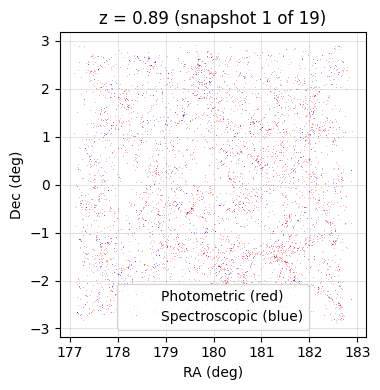

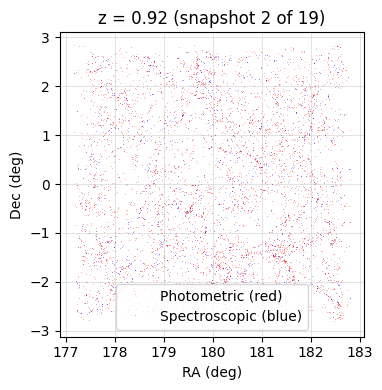

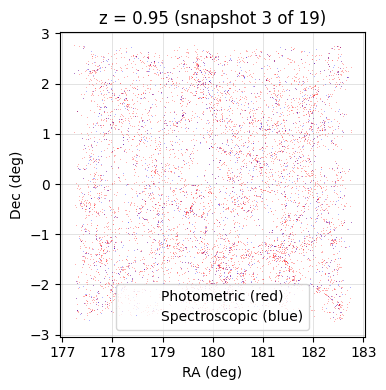

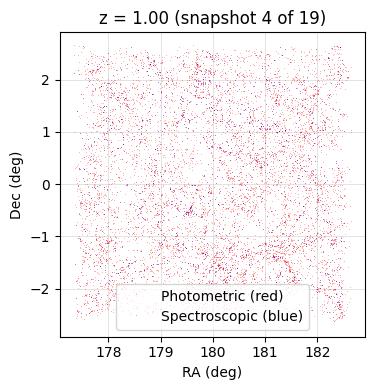

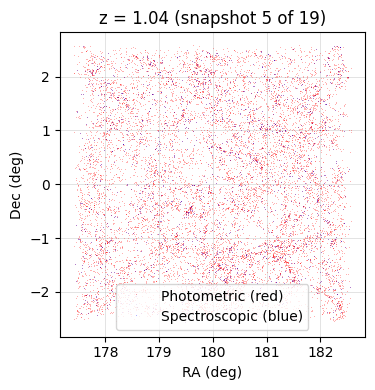

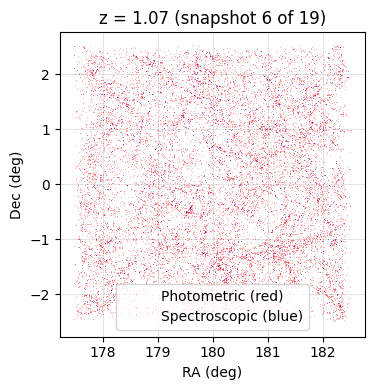

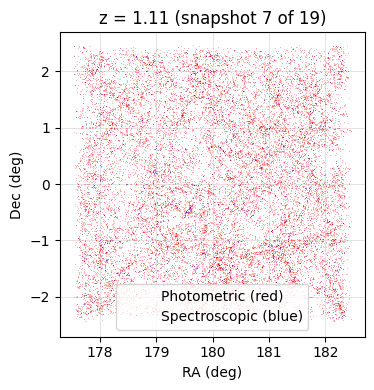

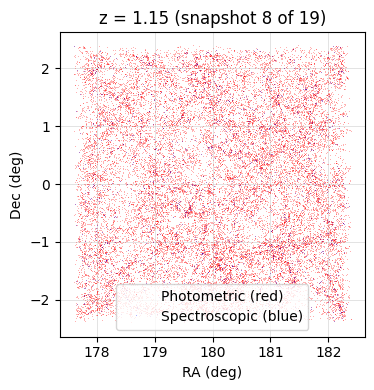

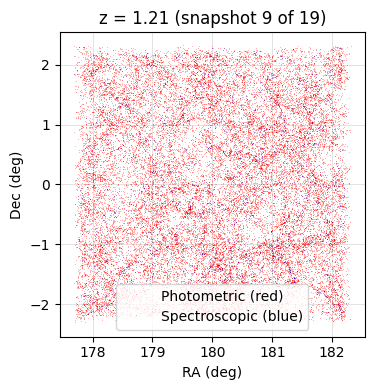

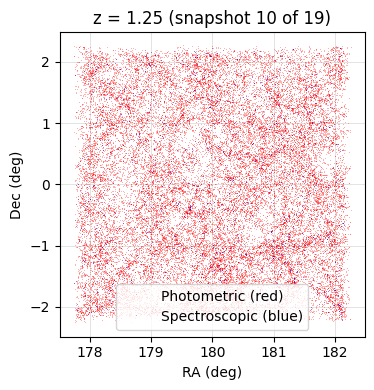

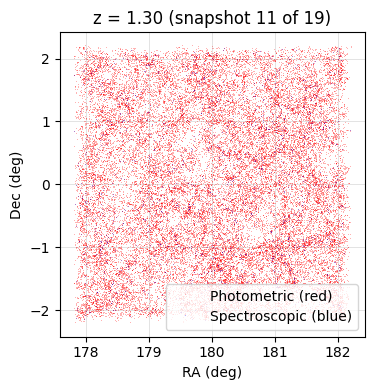

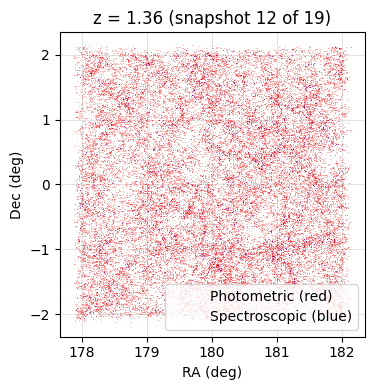

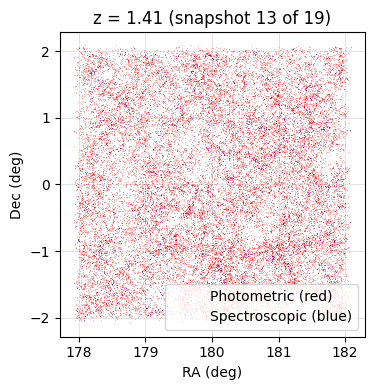

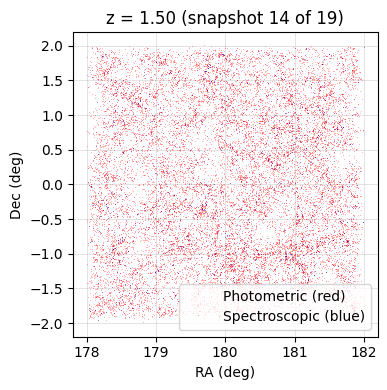

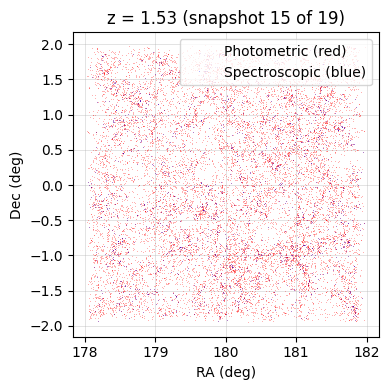

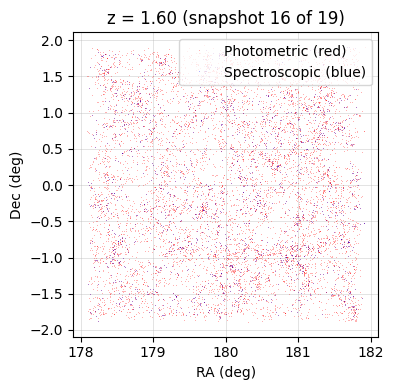

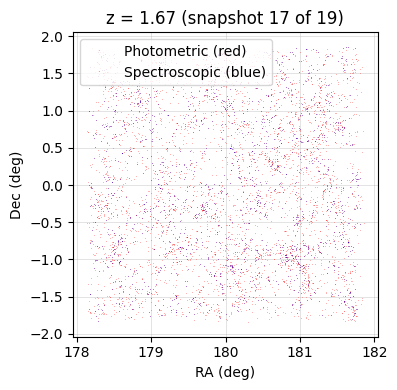

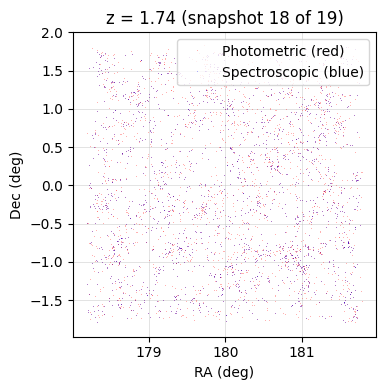

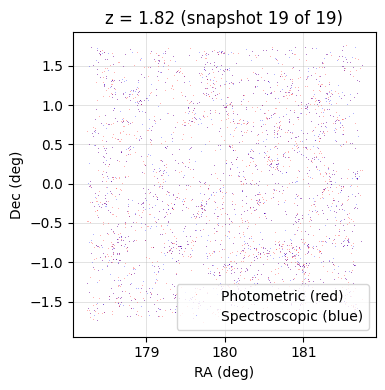

In [22]:
# plot some of the 2D data
gal_pos_phots = X._fetch_gal_pos_phots(None)
gal_pos_specs = X._fetch_gal_pos_specs(None)

theta_avg = np.full((len(X.snapshots), X.nbins), np.nan)
wthetax = np.copy(theta_avg)
for i, snapshot in enumerate(X.snapshots):
    # convert (x,y,z) -> (RA, Dec)
    ra_phot, dec_phot = tools.get_ra_dec(gal_pos_phots[i], X.chis[i])
    ra_spec, dec_spec = tools.get_ra_dec(gal_pos_specs[i], X.chis[i])

    # plot
    fig, ax = plt.subplots(figsize=(5,4), tight_layout=True)
    ax.plot(ra_phot, dec_phot, marker=',', alpha=0.3, c='r', ls='None', label='Photometric (red)')
    ax.plot(ra_spec, dec_spec, marker=',', alpha=0.3, c='b', ls='None', label='Spectroscopic (blue)')
    
    ax.grid(alpha=0.5, lw=0.5)
    ax.set_xlabel('RA (deg)')
    ax.set_ylabel('Dec (deg)')
    ax.set_aspect('equal')
    ax.set_title(f"z = {X.redshifts[i]:.2f} (snapshot {i+1} of {len(X.snapshots)})")
    ax.legend()

In [ ]:
# compute the photometric angular autocorrelation
